# [IAPR][iapr]: Lab 2 ‒  Object description

**Group ID:** 37

**Author 1 (sciper):** Michael Biselx    (283812)  
**Author 2 (sciper):** Bastien Darbellay (288406)   
**Author 3 (sciper):** Maria   Guerraoui (274578)  

**Release date:** 25.03.2022  
**Due date:** 08.04.2022 (11:59 pm)


## Important notes

The lab assignments are designed to teach practical implementation of the topics presented during class well as
preparation for the final project, which is a practical project which ties together the topics of the course.

As such, in the lab assignments/final project, unless otherwise specified, you may, if you choose, use external
functions from image processing/ML libraries like opencv and sklearn as long as there is sufficient explanation
in the lab report. For example, you do not need to implement your own edge detector, etc.

**! Before handling back the notebook <font color='red'> rerun </font>the notebook from scratch !**
`Kernel` > `Restart & Run All`

We will not rerun the notebook for you.


[iapr]: https://github.com/LTS5/iapr

---
## 0. Extract relevant data
We first need to extract the `lab-02-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [2]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-02-data'
data_part1 = os.path.join(data_base_path, data_folder, 'part1')
data_part2 = os.path.join(data_base_path, data_folder, 'part2')

tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

---
## Part 1
In the `lab-02-data/part1` folder, you will find 28x28 grey-scale pictures of handwritten "0" and "1".
These digits have been extracted from MNIST dataset (http://yann.lecun.com/exdb/mnist/).

Your goal is to extract, from each of those images, a 2-dimensional feature vector (i.e. 2 features) and to plot them all on a 2D graph.
If you have chosen good features, the vectors of the "0"'s should nicely cluster in one part of the plane and those of the "1"'s in another.

Please try:
1. Fourier Descriptors (15pts). 
    1. Implementation (10 pts).
    2. Showing invariance to rotation, translation and scaling (5 pts).
2. Additional method of your choice (5 pts)


**Note:** for the Fourier descriptors, the u_k signal has to be constructed by following the contour point after point. Some pre-processing (image binarization, possibly some Mathematical Morphology) might be useful.

### 1.1 Data visualization

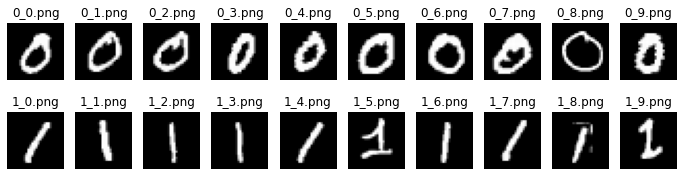

In [3]:
import skimage.io
import matplotlib.pyplot as plt
%matplotlib inline

def load(path, digit='0'):
    digit_path = os.path.join(path, digit)
    digit_names = [nm for nm in os.listdir(digit_path) if '.png' in nm]  # make sure to only load .png
    digit_names.sort()  # sort file names
    ic = skimage.io.imread_collection([os.path.join(digit_path, nm) for nm in digit_names])
    digit_im = skimage.io.concatenate_images(ic)
    return digit_im, digit_names
                        
#  Load zeros and ones
zeros_im, zeros_names = load(data_part1, digit='0')
ones_im, ones_names = load(data_part1, digit='1')


# Plot images
fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], zeros_im, zeros_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], ones_im, ones_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

### 1.2 Fourier descriptors (15 pts)

In [19]:
# Add your implementation and discussion
import skimage.measure
import skimage.transform
import numpy as np

def get_fourier_descriptors(img, nb_descr) : 
    # step 1 : extract longest continuous contour 
    all_cont  = skimage.measure.find_contours(img, 0.5*img.max())
    long_cont = max(all_cont, key=len)

    # step 2 : fourier transform the contour
    fft_cont = np.fft.fft(long_cont[:,0] + long_cont[:,1]*1j)

    # step 3 : extract the relevant descriptors (for uneven number of descriptors, default to positive side)
    descriptors = [];
    for n in range(1, int(nb_descr/2)+1) : 
        descriptors = [np.abs(fft_cont[-n])] + descriptors + [np.abs(fft_cont[n])]
    if n < nb_descr/2 : 
        descriptors.append(np.abs(fft_cont[n+1]))
        
    # step 4 : normalize descriptors 
    descriptors = descriptors / np.linalg.norm(descriptors)
    
    # ajdlfkaéjds
    fft_cont[int(nb_descr/2)+1:-int(nb_descr/2)] = 0;
    cont = np.fft.ifft(fft_cont)
    
    return descriptors, cont

    


def apply_random_transform(img) :
    translation = -2 + 4*np.random.random((1,2)) # translation = [-2  - +2]
    rotation = 360*np.random.random()            # rotation    = [0°  - 360°]
    scale = 0.9 + 0.1*np.random.random(1)        # scale       = [0.9 - 1.0]

    tform = skimage.transform.SimilarityTransform(scale = scale, translation=translation)
    img_r = skimage.transform.rotate(img, rotation)
    img_t = skimage.transform.warp(img_r, tform) # don't use rotation 
    
    return img_t

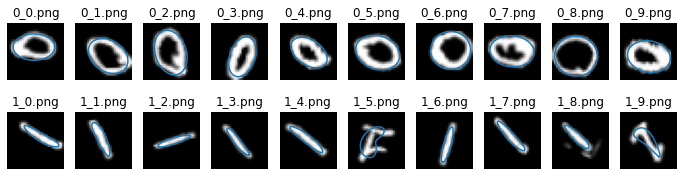

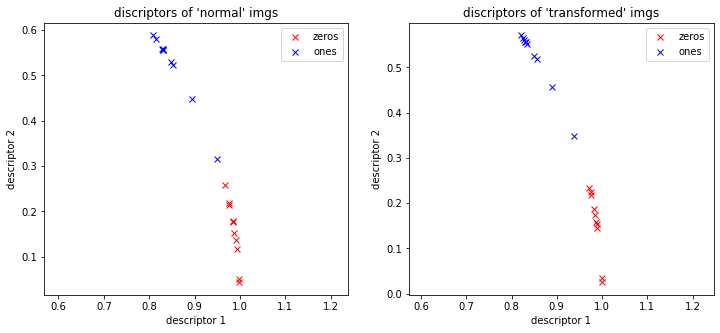

In [21]:
# GOAL : demonstrate the invnariance to transformation 

# get descriptors for the 'normal' images 
descriptors_0 = np.array([get_fourier_descriptors(img, 2)[0] for img in zeros_im])
descriptors_1 = np.array([get_fourier_descriptors(img, 2)[0] for img in ones_im])

# apply a random tranformation (rotation + scale + translation) to images
zeros_im_t = [apply_random_transform(im) for im in zeros_im]
ones_im_t = [apply_random_transform(im) for im in ones_im]

# get descriptors for the tranformed images
descriptors_0t = np.array([get_fourier_descriptors(im, 2)[0] for im in zeros_im_t])
descriptors_1t = np.array([get_fourier_descriptors(im, 2)[0] for im in ones_im_t])

# plot transformed images 
fig, axes = plt.subplots(2, len(zeros_im_t), figsize=(12, 3))
for ax, im, nm in zip(axes[0], zeros_im_t, zeros_names):
    ax.imshow(im, cmap='gray')
    cont = get_fourier_descriptors(im, 2)[1]
    ax.plot(cont.imag, cont.real, 'r')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], ones_im_t, ones_names):
    ax.imshow(im, cmap='gray')
    cont = get_fourier_descriptors(im, 4)[1]
    ax.plot(cont.imag, cont.real, 'b')
    ax.axis('off')
    ax.set_title(nm)

# plot descriptors 
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].plot(descriptors_0[:,0],descriptors_0[:,1], 'rx')
axes[0].plot(descriptors_1[:,0],descriptors_1[:,1], 'bx')
axes[0].set_title("discriptors of 'normal' imgs")

axes[1].plot(descriptors_0t[:,0],descriptors_0t[:,1], 'rx')
axes[1].plot(descriptors_1t[:,0],descriptors_1t[:,1], 'bx')
axes[1].set_title("discriptors of 'transformed' imgs")

for ax in axes : 
    ax.legend(["zeros", "ones"])
    ax.set_xlabel("descriptor 1")
    ax.set_ylabel("descriptor 2")
    ax.axis('equal')    

plt.show()

### 1.3 Additional method (5 pts)

In [6]:
def PolyArea(contour):
    return 0.5*np.abs(np.dot(contour[:,0],np.roll(contour[:,1],1))-np.dot(contour[:,1],np.roll(contour[:,0],1)))

def GetSurfaceArea(contour, shape="rectangle"):
    if shape == "rectangle":
        w = max(contour[:,0])-min(contour[:,0])
        h = max(contour[:,1])-min(contour[:,1])
        A = h*w
    elif shape == "ellipse":
        w = max(contour[:,0])-min(contour[:,0])
        h = max(contour[:,1])-min(contour[:,1])
        A = h*w*np.pi
    return A
        

def GetRatios(images, shape="rectangle"):
    ratios = []
    for img in images:
        contour = max(skimage.measure.find_contours(img, level=0.5*img.max()), key=len)
        A = GetSurfaceArea(contour, shape)
        P = PolyArea(contour)
        ratios.append(P/A)
    return ratios

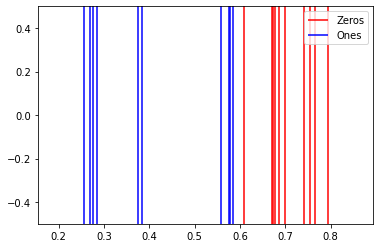

In [7]:
# Add your implementation and discussion
shape = "rectangle"
zeros_ratios = GetRatios(zeros_im, shape)
ones_ratios = GetRatios(ones_im, shape)

xmax = max(ones_ratios+zeros_ratios)+0.1
xmin = min(ones_ratios+zeros_ratios)-0.1
plt.figure()
#plt.hlines(0,xmin,xmax)  # Draw a horizontal line
plt.xlim(xmin,xmax)
plt.ylim(-0.5,0.5)
plt.eventplot(zeros_ratios, orientation='horizontal', lineoffset=0, colors='r', label='Zeros')
plt.eventplot(ones_ratios,  orientation='horizontal', lineoffset=0, colors='b', label='Ones')
#plt.set_title("test")
plt.axis('on')
plt.legend()
plt.show()

---
## Part 2
The `lab-02-data/part2` folder contains grey-scale pictures of handwritten "2" and "3".
Extract the same feature (typically 2 Fourier descriptors) as in part 1 also on these images and plot them on the same graph as the features of the "0" and "1".
Is it possible to discriminate all these 4 digits with a 2-dimensional feature vector?

### 2.1 Data visualization

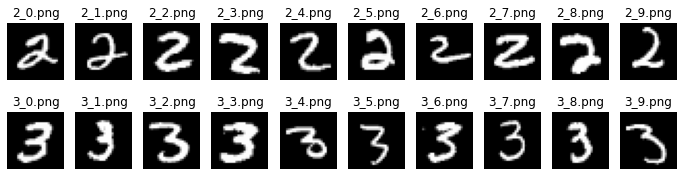

In [8]:
#  Load twos and threes
twos_im, twos_names = load(data_part2, digit='2')
threes_im, threes_names = load(data_part2, digit='3')

# Plot images
fig, axes = plt.subplots(2, len(twos_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], twos_im, twos_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], threes_im, threes_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

### 2.2 Fourier descriptors - 4 digits (10 pts)

In [9]:
# Add your implementation and discussion